In [2]:
import sys
import os
import glob
from mpi4py import MPI
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'

import floatpy.readers.padeops_reader as por
import floatpy.readers.parallel_reader as pdr
import floatpy.utilities.reduction as red
import floatpy.derivatives.compact.compact_derivative as cd
import scripts.statistics as stats
import scripts.get_namelist as nml
# from scripts.hh_decomp import window_tukey, window_field
from scripts.common import *

def get_L99(y,utilde,plotOpt=False):
    utop = 0.99*inp.du/2
    ubot = -0.99*inp.du/2
    ibot = np.argmin(abs(utilde[Ny/2:]-utop)[::-1])
    itop = np.argmin(abs(utilde[:Ny/2]-ubot)[::-1])+Ny/2
    L99 = y[itop]-y[ibot]
    if plotOpt:
        plt.plot(y,utilde)
        #plt.plot(y[:Ny/2],utilde[:Ny/2],'--')
        #plt.plot(y[Ny/2:],utilde[Ny/2:],'--')
        plt.plot([y[ibot],y[ibot]],[-inp.du/2.,inp.du/2.],'k:',label='bot')
        plt.plot([y[itop],y[itop]],[-inp.du/2.,inp.du/2.],'k--',label='top')
        plt.legend()
    return L99,itop,ibot

def integrate_y(y,f,method='midpoint'):
    ny = np.size(y)
    dy = abs(y[0]-y[1])
    I = 0.
    
    if method=='midpoint':
        for i in range(ny-1):
            I += dy*0.5*(f[i]+f[i+1])
            
    elif method=='simpsons':
        for i in range(ny-2):
            if i%2==0: I += dy/3.*(f[i]+4*f[i+1]+f[i+2])
                
    elif method=='trapz':
        for i in range(ny-1):
            I += dy*0.5*(f[i]+f[i+1])
            
    else: print('Invalid integration method {}'.format(method))
    return I

def window_tukey(n,N,alpha=0.5):
    tmp = alpha*N/2
    pi = np.pi

    if n<tmp:
        return 0.5*(1.+np.cos(pi*(n/tmp-1.)))
    elif n>=tmp and n<N*(1.-alpha/2.):
        return 1.
    elif n>=N*(1.-alpha/2.) and n<=N:
        return 0.5*(1.+np.cos(pi*(n/tmp-2./alpha+1.)))
    else:
        return 0

def window_field(filename_prefix,ychunk,yplot,du,tID,q,utilde=None,pad=0):
    if utilde is None:
        fname = filename_prefix+'utilde_%04d.dat'%tID
        try:
            utilde = np.fromfile(fname,count=-1,sep=' ')
        except:
            print('Write {}'.format(fname))
            sys.exit()
    L99, itop, ibot = get_L99(yplot,utilde)
    #print(L99, itop,ibot,y[itop],y[ibot])
    Ny = np.size(utilde)

    # Window based off 99% thickness
    ibot = max(ibot-pad,0)
    itop = min(itop+pad,Ny)
    N = abs(itop-ibot)      # total window size
    ny = np.shape(q)[1]     # size of chunk
    for iy_,ylocal in zip(range(ny),ychunk[0,:,0]):
        if ylocal>yplot[ibot] and ylocal<yplot[itop]:
            iy = np.argmin(abs(ylocal-yplot)) #global y index
            idx = iy-ibot # distance from bottom bound
            
            assert idx>=0
            assert idx<=N
            q[:,iy_,:] *= window_tukey(idx,N)
        else:
            q[:,iy_,:] = 0
    return q

def get_Rij(fname):
    dat = np.fromfile(fname,dtype=float, count=-1, sep=' ')
    n = np.size(dat)
    nstats=6
    dat = np.reshape(dat,[n/nstats,nstats])
    R11 = dat[:,0]
    R12 = dat[:,1]
    R13 = dat[:,2]
    R22 = dat[:,3]
    R23 = dat[:,4]
    R33 = dat[:,5]
    return R11,R12,R13,R22,R23,R33

directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr7/1024x1448x512/'
inp = nml.inputs(directory,verbose=True)
Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=True)
Ny = int(Ny)
y = np.linspace(-Ly/2.,Ly/2.,Ny)

flist = glob.glob(directory+"*Rij*")
flist.sort()
print([f.split('/')[-1] for f in flist])

tlist,dlist,rates = growth_rates(directory+'shearlayer_')

Params for this run:
	Mc = 0.2
	Re = 1000.0
	rr = 7.0
Params for this grid:
	N = 1024x1448x512
	L = 150.0x200.0x75.0
['shearlayer_Rij_0001.dat', 'shearlayer_Rij_0002.dat', 'shearlayer_Rij_0003.dat', 'shearlayer_Rij_0004.dat', 'shearlayer_Rij_0005.dat', 'shearlayer_Rij_0006.dat', 'shearlayer_Rij_0007.dat', 'shearlayer_Rij_0008.dat', 'shearlayer_Rij_0009.dat', 'shearlayer_Rij_0010.dat', 'shearlayer_Rij_0014.dat', 'shearlayer_Rij_0015.dat', 'shearlayer_Rij_0016.dat', 'shearlayer_Rij_0020.dat', 'shearlayer_Rij_0021.dat', 'shearlayer_Rij_0022.dat', 'shearlayer_Rij_0023.dat', 'shearlayer_Rij_0024.dat', 'shearlayer_Rij_0025.dat', 'shearlayer_Rij_0026.dat', 'shearlayer_Rij_0027.dat', 'shearlayer_Rij_0028.dat', 'shearlayer_Rij_0058.dat', 'shearlayer_Rij_0059.dat', 'shearlayer_Rij_0060.dat', 'shearlayer_Rij_0061.dat', 'shearlayer_Rij_0062.dat', 'shearlayer_Rij_0063.dat', 'shearlayer_Rij_0064.dat', 'shearlayer_Rij_0065.dat', 'shearlayer_Rij_0066.dat', 'shearlayer_Rij_0067.dat', 'shearlayer_Rij_00

37.59502418797511


Text(0.5,0,'y')

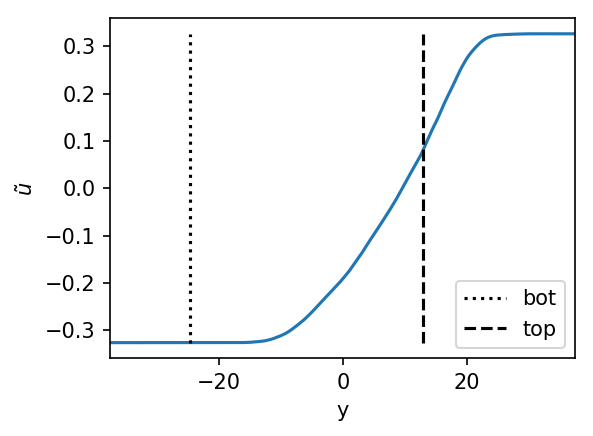

In [253]:

fig = plt.figure(figsize=(4,3),dpi=150)
tmp = glob.glob(directory+"*utilde*")
utilde=np.fromfile(tmp[-1],sep=' ')  
L99,i1,i2=get_L99(y,utilde,plotOpt=True) #itop,ibot
print(L99)


plt.xlim([-L99,L99])
plt.ylabel(r'$\tilde{u}$')
plt.xlabel('y')
# window_tukey(n,N,alpha=0.5):

(0.2, 7.0)


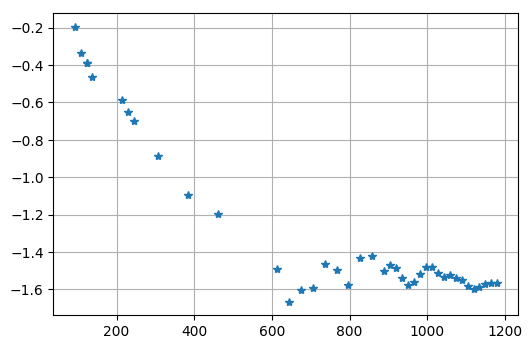

In [54]:
# Integrated profiles
# 1D integration in y using midpoint rule:

def integrate_Rij(directory,flist,name,method='midpoint',pad=0):
    mat = np.zeros([len(flist),2])
    for i,fname in enumerate(flist):
        tID = fname.split('/')[-1]
        tID = tID.split('_')[-1]
        tID = int(tID.split('.')[0])
        time = nml.read_time(directory,tID)

        # Get dtheta
        idx = np.argmin(abs(tlist-time))
        dtheta = dlist[idx]

        R11,R12,R13,R22,R23,R33 = get_Rij(fname)
        if name=='b12': dat = R12/(R11+R22+R33)
        elif name=='R11': dat = R11
        elif name=='R22': dat = R22
        elif name=='R12': dat = R12
        elif name=='R13': dat = R13
        elif name=='Rii': dat = R11+R22+R33
    
        # Do some windowing
#         if name=='b12':
#             Rii = R11+R22+R33
#             Rii = window_field(directory+'/shearlayer_',y[None,:,None],y,inp.du,tID,dat[None,:,None],pad=pad)
#             R12 = window_field(directory+'/shearlayer_',y[None,:,None],y,inp.du,tID,R12[None,:,None],pad=pad)
#             dat = R12/Rii
        if pad>0: dat = window_field(directory+'/shearlayer_',y[None,:,None],y,inp.du,tID,dat[None,:,None],pad=pad)
        #plt.plot(y/dtheta,np.squeeze(dat))
        
        # integrate
        mat[i,0] = time
        mat[i,1] = integrate_y(y,np.squeeze(dat),method=method)/dtheta
    # sort by time
    isort = np.argsort(mat[:,0]) #sort time
    return mat[isort,:]


fig = plt.figure(dpi=100)
dat = integrate_Rij(directory,flist[:],name='b12',pad=100)
plt.grid(True)
# plt.xlim([-20,20])
plt.plot(dat[:,0]/inp.du,dat[:,1],'*')
print(inp.Mc,inp.rr)

NameError: name 'integrate_Rij' is not defined

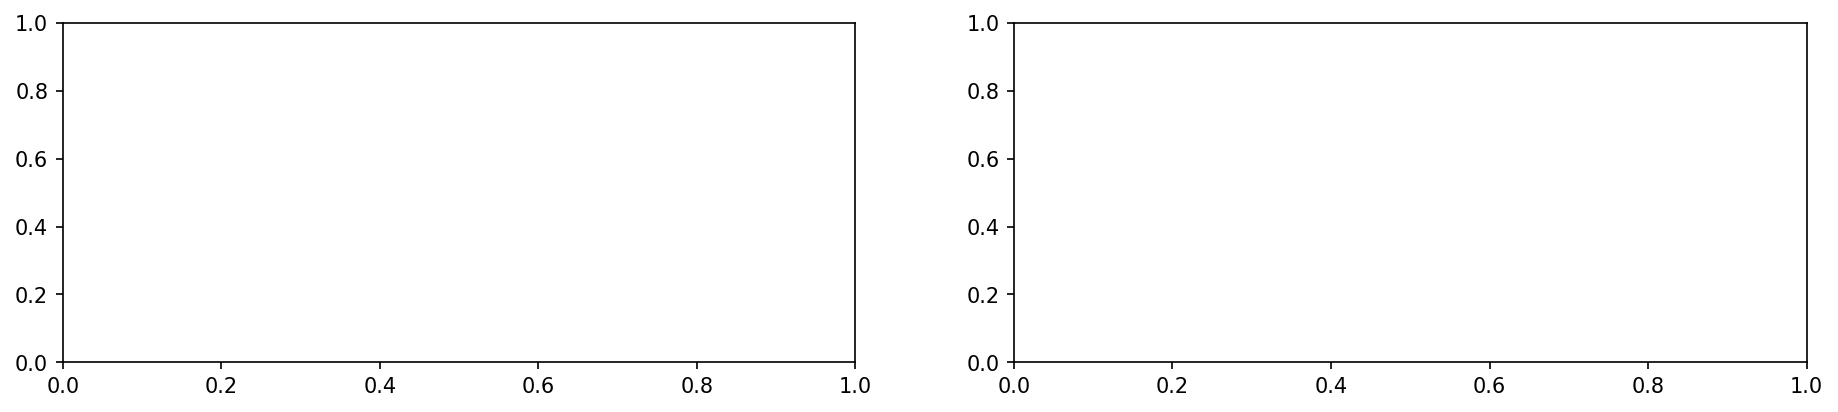

<Figure size 600x400 with 0 Axes>

In [3]:
s = '1'
Mc = '20'
gridlist = ['1024x1448x512','724x1024x362','512x724x256']
    
fig,ax = plt.subplots(1,2,figsize=(15,3),dpi=150)

for gridres in gridlist:
    directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc%s/rr%s/%s/'%(Mc,s,gridres)
    inp = nml.inputs(directory,verbose=False)
    Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=False)
    Ny = int(Ny)
    y = np.linspace(-Ly/2.,Ly/2.,Ny)

    flist = glob.glob(directory+"*Rij*")
    flist.sort()

    tlist,dlist,rates = growth_rates(directory+'shearlayer_')

    # Plot Rij
    fig = plt.figure(dpi=100)
    dat = integrate_Rij(directory,flist,name='R11',method='simpsons')
    ax[0].plot(dat[:,0],dat[:,1],'-*',label='{}'.format(gridres))
    
print('Done')
ax[0].grid(True)
ax[0].legend()
ax[0].set_xlabel(r'$t/\Delta U$')


In [1]:
s = '1'

if s=='1': Mc_list = ['02','04','08','12','16','20']
else: Mc_list = ['02','08','20']
    
fig = plt.figure(figsize=(5,3),dpi=150)

for Mc in Mc_list:
    directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
    inp = nml.inputs(directory,verbose=False)
    Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=False)
    Ny = int(Ny)
    y = np.linspace(-Ly/2.,Ly/2.,Ny)

    flist = glob.glob(directory+"*Rij*")
    flist.sort()

    tlist,dlist,rates = growth_rates(directory+'shearlayer_')

    if Mc=='02': ist=0;ien=-1
    elif Mc=='04': ist=0;ien=13-3
    else: ist=0; ien=-1
    
    Rij = 'R22'
    dat = integrate_Rij(directory,flist,name=Rij)
    t = dat[:,0]
    f = dat[:,1]/inp.du**2
    plt.plot(t[ist:ien],f[ist:ien],'-*',label='Mc = {}'.format(inp.Mc))
    #print('{}:[{},{}],'.format(inp.Mc,np.mean(f[2:ien]),np.std(f[2:ien])))
    
plt.grid(True)
plt.legend()
plt.xlabel(r'$t/\Delta U$')
plt.ylabel(r'$%s$'%Rij)
# ax.set_xlim([-20,900])
# ax[0].set_xlim([0,200])
plt.show()
savename='/home/kmatsuno/ShearLayer_img/vs_t/'+'%s_s%s'%(Rij,s)
fig.savefig(savename,dpi=200,bbox_inches='tight')
print(savename)


NameError: name 'plt' is not defined

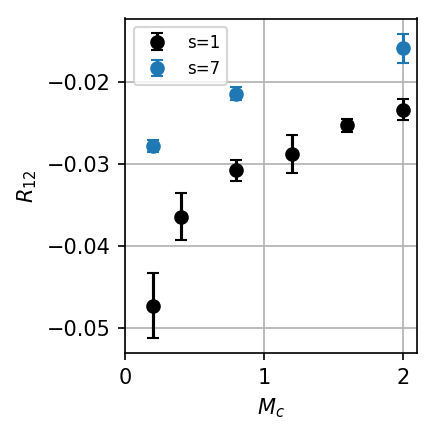

In [20]:
R11_s7 = {
0.2:[0.0863268287481,0.00114468402526],
0.8:[0.0688971679257,0.0040313693165],
2.0:[0.0609836030385,0.0059720205916],  
}
R22_s7 = {
0.2:[0.048979464079,0.000225547023389],
0.8:[0.0373104509981,0.00130857253815],
2.0:[0.0240881918955,0.00191021771496],
}
R12_s7 = {
0.2:[-0.0284904873524,0.000237718340301],
0.8:[-0.0213285830552,0.000698768021862],
2.0:[-0.016039174372,0.000697128483409],
}
R11_s_7 = {
0.2:[0.0858909940537,0.000668825462692],
0.8:[0.0734061748335,0.00138303046129],
2.0:[0.0579868294928,0.00594008778472], 
}
R22_s_7 = {
0.2:[0.0479586256984,0.00161770101334],
0.8:[0.0352194203934,0.00115435339626],
2.0:[0.0261978170184,0.00184399885719],
}
R12_s_7 = {
0.2:[-0.0270675369385,0.000634212921938],
0.8:[-0.0214696002967,0.00038217966246],
2.0:[-0.0156345869532,0.00161355412884],
}

fig = plt.figure(figsize=(3,3),dpi=150)
name='12'
if name=='11':
    s1 = R11
    s7 = merge_dicts(R11_s7,R11_s_7)
elif name=='22':
    s1 = R22
    s7 = merge_dicts(R22_s7,R22_s_7)
elif name=='12':
    s1 = R12
    s7 = merge_dicts(R12_s7,R12_s_7)
plotter(s1,'s=1','ko')
plotter(s7,'s=7','o')

plt.grid(True)
plt.xlabel(r'$M_c$')
plt.ylabel(r'$R_{%s}$'%(name))
plt.legend(fontsize=8)
plt.xlim([0,2.1])
plt.tight_layout()
# plt.savefig('/home/kmatsuno/ShearLayer_img/Rij.png',dpi=200, bbox_inches='tight')

0.140557425323
0.140557425323
0.140557425323


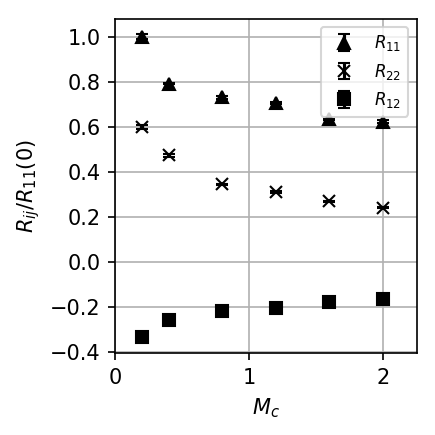

In [90]:
# Rij vs. Mc
R11 = {
0.2:[0.140557425323,0.0127414184429],
0.4:[0.111190360072,0.00385675644511],
0.8:[0.102653344945,0.0054012762016],
1.2:[0.0992832541374,0.00460475445374],
1.6:[0.0889674925522,0.00273798778062],
2.0:[0.0874140601037,0.00762821309543],
}
R22 = {
0.2:[0.0841744134611,0.00890705558576],
0.4:[0.0663689258373,0.00657149249635],
0.8:[0.0483441369705,0.00307560657028],
1.2:[0.0437361705394,0.00412798923024],
1.6:[0.0377072413456,0.000939069749731],
2.0:[0.0336320252372,0.00178601633212],
}
R12 = {
0.2:[-0.0472442666051,0.00397883131188],
0.4:[-0.0363942930741,0.00288691273782],
0.8:[-0.0307236926413,0.00129659419372],
1.2:[-0.0287421155822,0.00231053915621],
1.6:[-0.0252560445189,0.000818044859998],
2.0:[-0.023326245801,0.00126172748624],
}
R11_vreman = {
0.2:[0.853448275862069,0],
0.6:[0.7413793103448275,0],
0.8:[0.5732758620689655,0],
1.2:[0.5905172413793103,0],
}
R22_vreman = {
0.2:[0.6939655172413792,0],
0.6:[0.5301724137931034,0],
0.8:[0.3749999999999999,0],
1.2:[0.23275862068965558,0],
}
R12_vreman = {
0.2:[-0.43103448275862055,0],
0.6:[-0.3620689655172413,0],
0.8:[-0.25,0],
1.2:[-0.21551724137931028,0]
}

def normalize(d,val):
    print(val)
    for key in d.keys():
        d[key][0] /= val
    return d
def plotter(dat,label,fmt):
    plt.errorbar(dat.keys(),[x[0] for x in dat.values()], yerr=[x[1] for x in dat.values()],fmt=fmt,label=label,capsize=3)

fig = plt.figure(figsize=(3,3),dpi=150)
# plotter(R11,r'$R_{11}$','k^')
# plotter(R22,r'$R_{22}$','kx')
# plotter(R12,r'$R_{12}$','ks')
val = R11[0.2][0]
plotter(normalize(R11,val),r'$R_{11}$','k^')
plotter(normalize(R22,val),r'$R_{22}$','kx')
plotter(normalize(R12,val),r'$R_{12}$','ks')
# plotter(R11_vreman,r'$R_{11}$','r^')
# plotter(R22_vreman,r'$R_{22}$','rx')
# plotter(R12_vreman,r'$R_{12}$','rs')
# val = R11_vreman[0.2][0]
# plotter(normalize(R11_vreman,val),r'$R_{11}$','r^')
# plotter(normalize(R22_vreman,val),r'$R_{22}$','rx')
# plotter(normalize(R12_vreman,val),r'$R_{12}$','rs')

plt.grid(True)
plt.xlabel(r'$M_c$')
plt.ylabel(r'$R_{ij}/R_{11}(0)$')
plt.legend(fontsize=8)
plt.xlim([0,2.25])
plt.tight_layout()
# plt.savefig('/home/kmatsuno/ShearLayer_img/Rij.png',dpi=200, bbox_inches='tight')

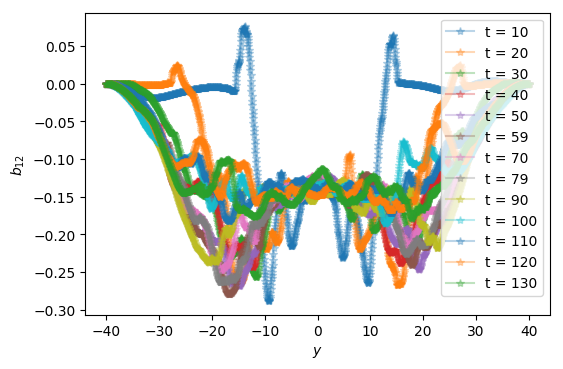

In [53]:
# Anisotropy profiles, windowed

fig = plt.figure(dpi=100)

flist_plot = flist[:]
for fname in flist_plot:
    tID = fname.split('/')[-1]
    tID = tID.split('_')[-1]
    tID = int(tID.split('.')[0])
    time = nml.read_time(directory,tID)
    
    R11,R12,R13,R22,R23,R33 = get_Rij(fname)
    b12 = R12/(R11+R22+R33)
    
    # Do some windowing
    try:
        b12_windowed = window_field(directory+'/shearlayer_',y[None,:,None],y,
                                    inp.du,tID,b12[None,:,None],pad=Ny/2)
    except: print('Write utilde for {}'.format(tID))
    plt.plot(y,np.squeeze(b12_windowed),'-*',alpha=0.3,label='t = %i'%time)
    
# plt.ylim([-0.3,0])
# plt.xlim([-20,20])
plt.ylabel('$b_{12}$')
plt.xlabel('$y$')
plt.legend()